## Setup

In [1]:
!pip -q install gym gym[atari] pyvirtualdisplay piglet
!apt-get -qq update
!apt-get -qq install python-opengl xvfb -y

In [2]:
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import io
import base64
from PIL import Image
from collections import namedtuple

import os
import glob
from gym.wrappers import Monitor
from itertools import count
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(
            HTML(
                data='''
                    <video alt="test" controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>
                '''.format(encoded.decode('ascii'))
            )
        )
    else: 
        print("Could not find video")

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def make_video(policy, env, reward_fn=None, max_episode_len=100, device='cpu'):

    env = wrap_env(env)
    obs = env.reset()
    state = torch.tensor(obs, device=device, dtype=torch.float32).unsqueeze(0)

    i = 0
    while i < max_episode_len:
        env.render()

        if reward_fn:
            print(*reward_fn(env, obs))

        action = select_action(policy, state)
        obs, _, done, _ = env.step(action.item())
        
        state = torch.tensor(obs, device=device, dtype=torch.float32).unsqueeze(0)

        if done:
            break
        i += 1
    env.close()

## Classes & Functions

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self, n_inputs, n_outputs):
        super(DQN, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.fc1 = nn.Linear(n_inputs, 50)
        self.head = nn.Linear(50, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.head(x)

In [6]:
def select_action(policy, state):
    with torch.no_grad():
        _, idx = policy(state).max(1)
        return idx.view(1, 1)

def select_action_eps(policy, state, epsilon=0.9, device='cpu'):
    if random.random() < epsilon:
        return select_action(policy, state)
    else:
        return torch.tensor([[random.randrange(policy.n_outputs)]],
                            device=device,
                            dtype=torch.long)

In [7]:
def optimize_model(policy, target, memory, loss_fn=F.smooth_l1_loss, batch_size=32, gamma=0.9):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                  device=device,
                                  dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a)
    state_action_values = policy(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1})
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch + (next_state_values * gamma)

    loss = loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [8]:
def cartpole_reward_fn(env, obs):
    x, d_x, theta, d_theta = obs
    r1 = (env.x_threshold - abs(x)) / env.x_threshold
    r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians
    return r1, r2

def acrobot_reward_fn(env, obs):
    cos_theta_1, sin_theta_1, cos_theta_2, sin_theta_2, d_theta_1, d_theta_2 = obs
    r1 = (1 - cos_theta_1) / 2
    r2 = (1 - cos_theta_2) / 2
    return r1, r2

In [9]:
def train(env,
          policy, target,
          optimizer, memory,
          reward_fn=(lambda env, obs: 1),
          loss_fn=F.smooth_l1_loss,
          num_episodes=100,
          max_episode_len=10000,
          target_update=10,
          print_every=10,
          device='cpu'):

    episodes = []
    i = 0

    while True:

        episode_losses = []
        
        obs = env.reset()
        state = torch.tensor(obs, device=device, dtype=torch.float32).unsqueeze(0)
        
        for t in count():
            
            env.render()

            action = select_action_eps(policy, state, epsilon=0.5, device=device)
            obs, _, done, _ = env.step(action.item())
            
            r = sum(reward_fn(env, obs))

            next_state = torch.tensor(obs, device=device, dtype=torch.float32).unsqueeze(0)
            reward = torch.tensor([r], device=device, dtype=torch.float32)
            
            memory.push(state, action, next_state, reward)

            # once memory is full, start learning
            if len(memory) == memory.capacity:
                
                loss = optimize_model(policy, target, memory, loss_fn=loss_fn)
                episode_losses.append(loss)

                if done or t+1 == max_episode_len:
                    episode = {
                        'i': i+1,
                        'duration': t+1,
                        'avg_loss': np.mean(episode_losses)
                    }
                    episodes.append(episode)
                    i += 1
                    break
            
            if done or t+1 == max_episode_len:
                break
            state = next_state

        if (i + 1) % print_every == 0:
            print(i+1)
                
        if (i + 1) % target_update == 0:
            target.load_state_dict(policy.state_dict())

        if (i + 1) == num_episodes:
            break

    return episodes

In [10]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
    
def plot_durations(durations, avg_window=25):
    avgs = moving_average(durations, avg_window)
    plt.plot(durations)
    plt.plot(avgs)
    plt.show()   

def plot_losses(losses):
    plt.plot(losses)
    plt.show()

## Train

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
env = gym.make('Acrobot-v1').unwrapped
#env = gym.make('Cartpole-v1').unwrapped
obs = env.reset()


n_inputs = len(obs)
n_actions = env.action_space.n

policy_net = DQN(n_inputs, n_actions).to(device)
target_net = DQN(n_inputs, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


optimizer = optim.Adam(policy_net.parameters(), lr=1e-2)
memory = ReplayMemory(2000)

In [13]:
episodes = train(env,
                 policy_net,
                 target_net,
                 optimizer,
                 memory,
                 reward_fn=acrobot_reward_fn,
                 loss_fn=F.smooth_l1_loss,
                 num_episodes=500,
                 max_episode_len=200,
                 target_update=10,
                 print_every=50,
                 device=device)

50
100
150
200
250
300
350
400
450
500


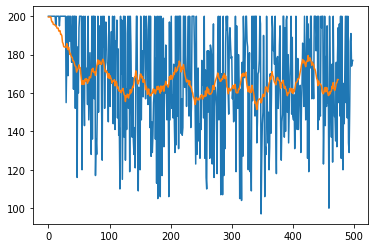

In [14]:
durations = [e['duration'] for e in episodes]
plot_durations(durations)

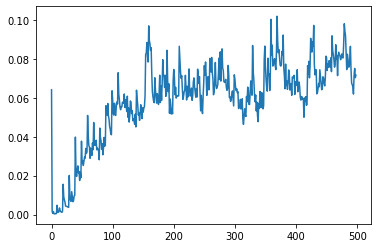

In [15]:
losses = [e['avg_loss'] for e in episodes]
plot_losses(losses)

## Test

In [16]:
make_video(policy_net,
           env,
           reward_fn=acrobot_reward_fn,
           max_episode_len=200,
           device=device)

0.000943749052604026 0.002230957381171461
0.0017745111003631409 0.0009596702480975661
0.003326168034202548 0.00032891645444343975
0.00514799346646444 0.007568734399715171
0.006112505247766908 0.02502827366198601
0.0052754759633535375 0.04656624194775588
0.0029731315636529754 0.0625122109361233
0.0007541115994499359 0.06687825093074062
0.0002090131954959329 0.04556300499288524
0.005295551145631128 0.009071660571188134
0.016942160394329442 0.004233253778741286
0.02759481229177929 0.04836088500179836
0.02745139029434346 0.10855877554478865
0.015855448281337836 0.14275328360920553
0.0019619281726876436 0.11416815533065394
0.004952168035724069 0.03741711421315563
0.03506885334933957 0.0003380866348281497
0.07317809624013594 0.05111834824874445
0.08666842329093388 0.1360632544671116
0.06295393745849603 0.18159107384690515
0.018512901388597847 0.13728434463556694
0.0013429626318018917 0.033343830100540706
0.048260160527044516 0.007236133353729746
0.1266079004727797 0.10470459174408392
0.17068

In [17]:
show_video()